In [439]:
import numpy as np
from PIL import Image, ImageFilter
import time
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.optimize import differential_evolution as DE

In [83]:
def show_hist(input_img):

    input_img_arr = np.array(input_img)
    
    r_img = input_img_arr[:,:,0]
    g_img = input_img_arr[:,:,1]
    b_img = input_img_arr[:,:,2]

    bins = np.arange(0,257,1)
    
    r_img_hist = np.histogram(r_img,bins=bins)
    g_img_hist = np.histogram(g_img,bins=bins)
    b_img_hist = np.histogram(b_img,bins=bins)


    fig, axes = plt.subplots(1,3,figsize=(15,5))
    xrange = np.arange(0,256,1) 
        
    axes[0].bar(xrange,r_img_hist[0])
    axes[1].bar(xrange,g_img_hist[0])
    axes[2].bar(xrange,b_img_hist[0])

    plt.show()

In [470]:
def stretch_helper(img, l=0):
    
    limit_l = int(255 * l)
    limit_h = 255 - limit_l
    
    min_val = img.min()
    max_val = img.max()
    out = np.array(((img - min_val)/(max_val - min_val))*(limit_h-limit_l) + limit_l)
    out = out.astype(int)      
    return out

def image_stretch(input_img, r_l, g_l, h_l):
        
    input_img = np.array(input_img).astype('int')

    
    r_img = input_img[:,:,0]
    g_img = input_img[:,:,1]
    b_img = input_img[:,:,2]

    
    r_stretched = stretch_helper(r_img,r_l).copy()
    g_stretched = stretch_helper(g_img,g_l).copy()
    b_stretched = stretch_helper(b_img,h_l).copy()
    
    
    output_img = np.zeros(input_img.shape).astype('uint8')
    output_img[:,:,0] = r_stretched
    output_img[:,:,1] = g_stretched
    output_img[:,:,2] = b_stretched      

    
    return output_img
    

In [472]:
def obj_function(x=[0,0,0], img=None ,stretch='no'):
    
    (r_l,g_l,b_l) = x
            
    new_img_arr = np.array(img)
    
    if stretch=='yes':
        new_img_arr = np.array(image_stretch(img,r_l,g_l,b_l))   
        
    new_img = Image.fromarray(new_img_arr)
    
    img_entropy = new_img.entropy() # entropy computation
    
    r_img_arr = new_img_arr[:,:,0]
    g_img_arr = new_img_arr[:,:,1]
    b_img_arr = new_img_arr[:,:,2]
    
    # gradient calculation
    (rdx,rdy) = np.array(np.gradient(r_img_arr))
    (gdx,gdy) = np.array(np.gradient(g_img_arr))
    (bdx,bdy) = np.array(np.gradient(b_img_arr))
    
    shape_img = r_img_arr.shape
    
    r_img_grad = np.sum(np.sqrt(rdx ** 2 + rdy ** 2))/(shape_img[0] * shape_img[1])
    g_img_grad = np.sum(np.sqrt(gdx ** 2 + gdy ** 2))/(shape_img[0] * shape_img[1])
    b_img_grad = np.sum(np.sqrt(bdx ** 2 + bdy ** 2))/(shape_img[0] * shape_img[1])
    
    grad_avg = (r_img_grad + g_img_grad + b_img_grad)/3
    val = img_entropy + grad_avg       # final objective
    return -val
    
    

Initial objective value:  13.441032633593185
Objective value after optimization:  19.358502513106433
Best combination of limits:  [0.00255766 0.00115255 0.0001738 ]
Final objective value:  33.45924324971689


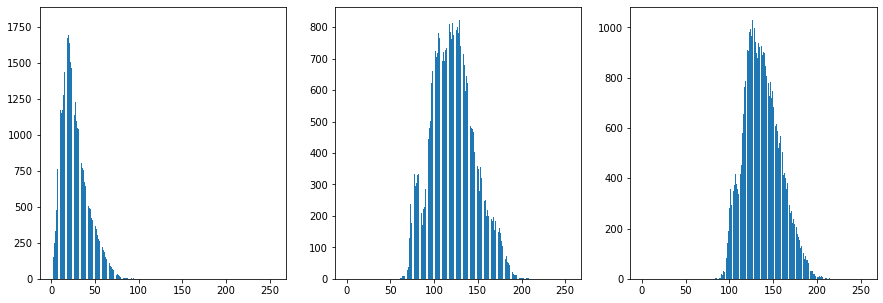

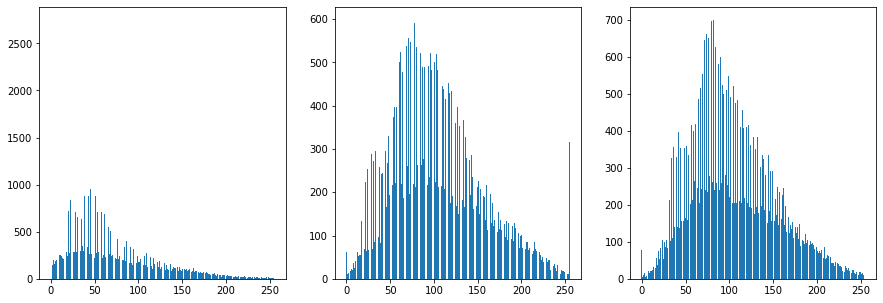

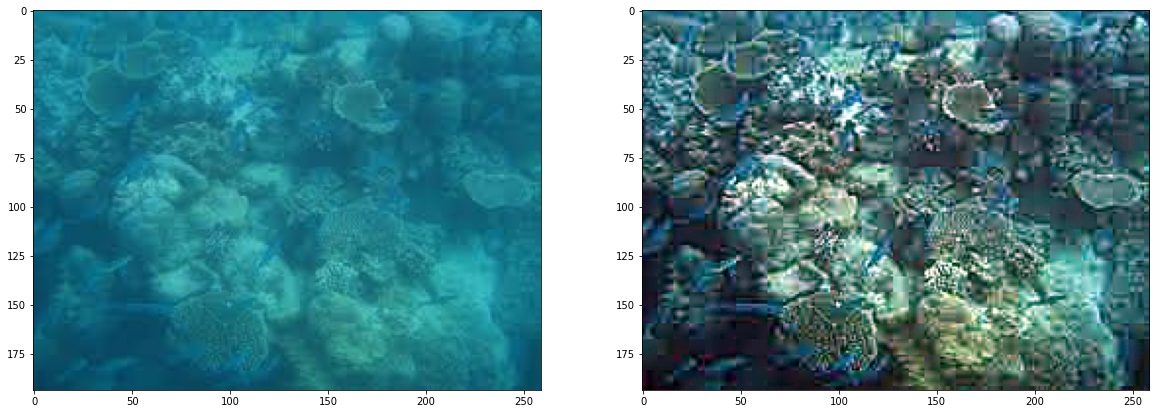

In [476]:
img_PATH = 'uwater02.jpeg' # Mention the path of the input image
input_img = Image.open(img_PATH)
input_img_arr = np.array(input_img)
print('Initial objective value: ',-obj_function(img=input_img_arr))

# optimization using Differential Evolution
bounds = [(0,0.5), (0,0.5), (0,0.5)]
results = DE(func=obj_function,args=(input_img_arr,'yes'),bounds = bounds, popsize = 40, maxiter = 1000, mutation=(0.8,0.8))
l = results.x
best_val = results.fun
print('Objective value after optimization: ',-best_val)
print('Best combination of limits: ',l)

# Sharpening of the final image
output_img = Image.fromarray(image_stretch(input_img, l[0], l[1], l[2]))
output_img = output_img.filter(ImageFilter.UnsharpMask()) # unsharp mask
print('Final objective value: ', -obj_function(img=output_img))

# Histogram plots and final images
show_hist(input_img)
show_hist(output_img)    
    
figs, axes = plt.subplots(1,2,figsize=(20,15))
    
axes[0].imshow(input_img)
axes[1].imshow(output_img) 